## 1. Załadowanie danych i bibliotek

In [1]:
# Packages
import pandas as pd 
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn import preprocessing 
from sklearn import metrics
import random
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')

# Grain setting guarantees the reproductibility of results
np.random.seed(123)
# Showing all columns in DataFrame preview
pd.set_option('display.max_columns', None)

# Loading data
data = pd.read_csv('german_credit_data_dataset.csv')
data = pd.DataFrame(data)
data.head()

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,present_residence,property,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,customer_type
0,A11,6,A34,A43,1169.0,A65,A75,4.0,A93,A101,4.0,A121,67.0,A143,A152,2.0,A173,1,A192,A201,1
1,A12,48,A32,A43,5951.0,A61,A73,2.0,A92,A101,2.0,A121,22.0,A143,A152,1.0,A173,1,A191,A201,2
2,A14,12,A34,A46,2096.0,A61,A74,2.0,A93,A101,3.0,A121,49.0,A143,A152,1.0,A172,2,A191,A201,1
3,A11,42,A32,A42,7882.0,A61,A74,2.0,A93,A103,4.0,A122,45.0,A143,A153,1.0,A173,2,A191,A201,1
4,A11,24,A33,A40,4870.0,A61,A73,3.0,A93,A101,4.0,A124,53.0,A143,A153,2.0,A173,2,A191,A201,2


In [2]:
# Training and test sets split
# 80% of observations belong to the training set the rest to the test
X_train, X_test, Y_train, Y_test = train_test_split(data.drop('customer_type', axis=1), data['customer_type'])

## 2. XGBoost for James-Stein Encoding

In [3]:
#train dataframe
dtrain = pd.concat([X_train,Y_train], axis=1)

#test dataframe
dtest = pd.concat([X_test,Y_test], axis=1)

target = "customer_type"

# Selection of columns to be encoded
cols = data.select_dtypes(include = 'object').columns.values 

# Building the encoder
encoder = ce.JamesSteinEncoder(cols = cols)

#encoding train dataframe
dtrain = encoder.fit_transform(X = dtrain, y = dtrain[target])
#changing target labels to binary labels for binary xboost algorithm 1 -> 1 (good customer), 2 -> 0 (bad customer) 
dtrain[target] = dtrain[target].map({1:1, 2:0})

#encoding test dataframe
dtest = encoder.transform(X = dtest)
#changing target labels to binary labels for binary xboost algorithm 1 -> 1 (good customer), 2 -> 0 (bad customer) 
dtest[target] = dtest[target].map({1:1, 2:0})

predictors = [x for x in dtrain.columns if x not in [target]]

In [4]:
# Function which finds the optimum number of trees (n_estimators parameter) using cv function of xgboost
# for given learning_rate and changes the alg parameter accrodingly
def modelfit(alg, dtrain, predictors, cv_folds = 5, early_stopping_rounds = 50):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'],
                      nfold=cv_folds, metrics='auc', early_stopping_rounds = early_stopping_rounds)
    alg.set_params(n_estimators = cvresult.shape[0])

In [5]:
# Our default calssifier, whose parameters will be tuned in grid_search_cv
xgb1 = xgb.XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 1000,
 max_depth = 5,
 min_child_weight = 1,
 gamma = 0,
 subsample = 0.8,
 colsample_bytree = 0.8,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

# Firstly let's assume fixed learning_rate = 0.1 and find optimum n_estiamtors parameter value for it
modelfit(xgb1, dtrain, predictors)

### 2.1. Tune max_depth and min_child_weight

In [6]:
model1 = Pipeline([
  ('classifier', xgb1)
])

# Parametred which will be tested in grid_search_cv
parameters = {
    'classifier__max_depth': range (2, 10, 1),
    'classifier__min_child_weight': range(1,10,1)
}

gsearch1 = GridSearchCV(model1, param_grid = parameters, cv = 5)
gsearch1.fit(dtrain[predictors], dtrain[target])
gsearch1.best_params_

{'classifier__max_depth': 8, 'classifier__min_child_weight': 5}

In [7]:
# let's replace our estimator with the best one
xgb2 = gsearch1.best_estimator_.steps[0][1]
# find the optimum n_estimators parameter
modelfit(xgb2, dtrain, predictors)

### 2.2. Tune gamma

In [8]:
model2 = gsearch1.best_estimator_

# Parametred which will be tested in grid_search_cv
parameters = {
    'classifier__gamma': [i/10.0 for i in range(0,5)],
}

gsearch2 = GridSearchCV(model2, param_grid = parameters, cv = 5)
gsearch2.fit(dtrain[predictors], dtrain[target])
gsearch2.best_params_

{'classifier__gamma': 0.0}

In [9]:
# let's replace our estimator with the best one
xgb3 = gsearch2.best_estimator_.steps[0][1]
# find the optimum n_estimators parameter
modelfit(xgb3, dtrain, predictors)

### 2.3. Tune subsample and colsample_bytree

In [10]:
model3 = gsearch2.best_estimator_

# Parametred which will be tested in grid_search_cv
parameters = {
    'classifier__subsample':[i/100.0 for i in range(50,100,5)],
    'classifier__colsample_bytree':[i/100.0 for i in range(50,100,5)]
}

gsearch3 = GridSearchCV(model3, param_grid = parameters, cv = 5)
gsearch3.fit(dtrain[predictors], dtrain[target])
gsearch3.best_params_

{'classifier__colsample_bytree': 0.85, 'classifier__subsample': 0.55}

### 2.4. Tune learning_rate

In [11]:
# let's replace our estimator with the best one and lower learning rate to get more trees 
xgb4 = gsearch3.best_estimator_.steps[0][1]
xgb4.set_params(learning_rate = 0.01)
# We also have to increase n_estimators so that number of trees wouldn't limit learning rate
xgb4.set_params(n_estimators = 5000)
# After all just find the optimum n_estimators parameter for changed learning_rate
modelfit(xgb3, dtrain, predictors)
#final model
model4 = Pipeline([
  ('classifier', xgb4)
])

### 2.5. Final James-Stein encoding model

In [12]:
model4.fit(dtest[predictors], dtest[target])

predict_class1 = model4.predict(dtest[predictors])
predict_proba1 = model4.predict_proba(dtest[predictors])[:, 1]


## 3. XGBoost for One Hot Encoding

In [13]:
#train dataframe
dtrain = pd.concat([X_train,Y_train], axis=1)

#test dataframe
dtest = pd.concat([X_test,Y_test], axis=1)

# Building the encoder
onehot_encoder = ce.OneHotEncoder(data, cols = cols)

#encoding train dataframe
dtrain = onehot_encoder.fit_transform(X = dtrain, y = dtrain["customer_type"])
#changing target labels to binary labels for binary xboost algorithm 1 -> 1 (good customer), 2 -> 0 (bad customer) 
dtrain["customer_type"] = dtrain["customer_type"].map({1:1, 2:0})

#encoding test dataframe
dtest = onehot_encoder.transform(X = dtest)
#changing target labels to binary labels for binary xboost algorithm 1 -> 1 (good customer), 2 -> 0 (bad customer) 
dtest["customer_type"] = dtest["customer_type"].map({1:1, 2:0})

predictors = [x for x in dtrain.columns if x not in [target]]

In [14]:
# Our default calssifier, whose parameters will be tuned in grid_search_cv
xgb1 = xgb.XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 1000,
 max_depth = 5,
 min_child_weight = 1,
 gamma = 0,
 subsample = 0.8,
 colsample_bytree = 0.8,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

# Firstly let's assume fixed learning_rate = 0.1 and find optimum n_estiamtors
# parameter value for it
modelfit(xgb1, dtrain, predictors)

### 3.1. Tune max_depth and min_child_weight

In [15]:
model1 = Pipeline([
  ('classifier', xgb1)
])

# Parametred which will be tested in grid_search_cv
parameters = {
    'classifier__max_depth': range (2, 10, 1),
    'classifier__min_child_weight': range(1,10,1)
}

gsearch1 = GridSearchCV(model1, param_grid = parameters, cv = 5)
gsearch1.fit(dtrain[predictors], dtrain[target])
gsearch1.best_params_

{'classifier__max_depth': 2, 'classifier__min_child_weight': 4}

In [16]:
# let's replace our estimator with the best one
xgb2 = gsearch1.best_estimator_.steps[0][1]
# find the optimum n_estimators parameter
modelfit(xgb2, dtrain, predictors)

### 3.2. Tune gamma


In [17]:
model2 = gsearch1.best_estimator_

# Parametred which will be tested in grid_search_cv
parameters = {
    'classifier__gamma': [i/10.0 for i in range(0,5)],
}

gsearch2 = GridSearchCV(model2, param_grid = parameters, cv = 5)
gsearch2.fit(dtrain[predictors], dtrain[target])
gsearch2.best_params_

{'classifier__gamma': 0.0}

In [18]:
# let's replace our estimator with the best one
xgb3 = gsearch2.best_estimator_.steps[0][1]
# find the optimum n_estimators parameter
modelfit(xgb3, dtrain, predictors)

### 3.3. Tune subsample and colsample_bytree


In [19]:
model3 = gsearch2.best_estimator_

# Parametred which will be tested in grid_search_cv
parameters = {
    'classifier__subsample':[i/100.0 for i in range(50,100,5)],
    'classifier__colsample_bytree':[i/100.0 for i in range(50,100,5)]
}

gsearch3 = GridSearchCV(model3, param_grid = parameters, cv = 5)
gsearch3.fit(dtrain[predictors], dtrain[target])
gsearch3.best_params_

{'classifier__colsample_bytree': 0.65, 'classifier__subsample': 0.85}

### 3.4. Tune learning_rate

In [20]:
# let's replace our estimator with the best one and lower learning rate to get more trees 
xgb4 = gsearch3.best_estimator_.steps[0][1]
xgb4.set_params(learning_rate = 0.01)
# We also have to increase n_estimators so that number of trees wouldn't limit learning rate
xgb4.set_params(n_estimators = 5000)
# After all just find the optimum n_estimators parameter for changed learning_rate
modelfit(xgb3, dtrain, predictors)
#final model
model4 = Pipeline([
  ('classifier', xgb4)
])

In [21]:
model4.fit(dtest[predictors], dtest[target])

predict_class2 = model4.predict(dtest[predictors])
predict_proba2 = model4.predict_proba(dtest[predictors])[:, 1]


## 4. Wyniki

In [25]:
Y_test = Y_test.map({1:1, 2:0})

fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test, predict_proba1) # false & true positive rates
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_test, predict_proba2) # false & true positive rates

pd.DataFrame({"Encoder" : ["James-Stein Encoding", "One Hot Encoding"],
             "AUC": [metrics.auc(fpr1, tpr1), metrics.auc(fpr2, tpr2)]})

,Encoder,AUC
0,James-Stein Encoding,0.972488
1,One Hot Encoding,0.996008


In [26]:
pd.DataFrame({"Encoder" : ["James Stein Encoding", "One Hot Encoding"],
             "Precision": [precision_score(Y_test, predict_class1, average='macro'), precision_score(Y_test, predict_class2, average='macro')],
             "Recall": [recall_score(Y_test, predict_class1), recall_score(Y_test, predict_class2)]})

,Encoder,Precision,Recall
0,James Stein Encoding,0.900491,0.952381
1,One Hot Encoding,0.969738,0.988095


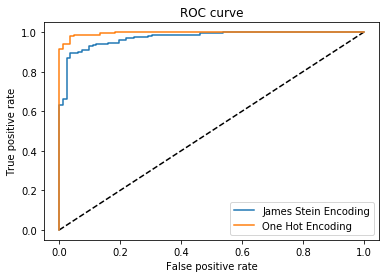

In [27]:
# ROCR curve
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='James Stein Encoding')
plt.plot(fpr2, tpr2, label='One Hot Encoding')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()